In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm


class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, d_model, n_channels):
        """
        将输入图片(BS, C, H, W)划分为patches(BS, num_patches, d_model)

        img_size: (H, W) 图片大小
        patch_size: (ph, pw) patch大小
        d_model: 每个patch/token的嵌入维度
        n_channels: 输入图片的通道数
        """
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.d_model = d_model
        self.n_channels = n_channels
        self.patcher = nn.Conv2d(in_channels=n_channels, out_channels=d_model, kernel_size=patch_size, stride=patch_size)
        self.flatten = nn.Flatten(start_dim=2)


    def forward(self, x):   # x:(BS, C, H, W)
        x = self.patcher(x)      # (BS, C, H, W)->(BS, d_model, H//ph, W//pw)
        x = self.flatten(x)      # (BS, d_model, H//ph * W//pw) = (BS, d_model, num_patches)
        x = x.transpose(-1, -2)   # (BS, d_model, num_patches)->(BS, num_patches, d_model)
        return x                 # (BS, num_patches, d_model)




class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        """
        给经过patch的输入加上class_token和位置编码，然后直接输入到TransformerEncoder中
        d_model: 每个patch/token的嵌入维度，也是位置编码每个位置的嵌入维度
        max_seq_length: 1+num_patches， 包括class_token在内的总的tokens数
        """
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        self.cls_token = nn.Parameter(data=torch.randn(size=(1, 1, d_model)), requires_grad=True)
        # 第一个1指BS维度，第二个1指只有1个token，第三个d_model指这个token的嵌入维度
#         self.pe = nn.Parameter(data=torch.randn(size=(1, max_seq_length, d_model)), requires_grad=True)

        pe = torch.zeros(max_seq_length, d_model)   # 使用全0初始化位置编码pe
        # 位置编码采用固定的正余弦位置编码
        # 对于每个位置pos的嵌入[0,0,...,0]共d_model个0
        # 对于第i个0，
        # 如果i是偶数，则取值sin(pos/(10000**(i/d_model)))
        # 如果i是奇数，则取值cos(pos/(10000**((i-1)/d_model)))
        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos/(10000**(i/d_model)))
                else:
                    pe[pos][i] = np.cos(pos/(10000**((i-1)/d_model)))

        pe = pe.unsqueeze(0)  # (max_seq_length, d_model)->(1, max_seq_length, d_model)
        self.register_buffer("pe", pe)
        # 将变量pe注册为模型的参数，但是不会被优化器更新，是固定的，可以通过self.pe来调用
        # 当模型被保存下来的时候，参数pe也会被保存下来




    def forward(self, x):    # x来自PatchEmbedding   (BS, num_patches, d_model)
        cls_tokens = self.cls_token.expand(size=(x.shape[0], -1, -1))    # (1, 1, d_model)->(BS, 1, d_model)
        x = torch.cat([cls_tokens, x], dim=1)     # (BS, 1, d_model)(BS, num_patches, d_model)->(BS, 1+num_patches, d_model)
        x = x + self.pe   # (BS, 1+num_patches, d_model)+(1, max_seq_length, d_model)=(BS, 1+num_patches, d_model)
        return x     # (BS, 1+num_patches, d_model)



# 自注意力模块，首先计算单头注意力
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        """
        计算单头注意力
        d_model: 每个patch/token的嵌入维度
        head_size: 每个头中每个patch/token的嵌入维度
        """
        super(AttentionHead, self).__init__()
        self.d_model = d_model
        self.head_size = head_size

        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)


    def forward(self, x):   # x: (BS, 1+num_patches, d_model)
        Q = self.query(x)   # (BS, 1+num_patches, d_model)->(BS, 1+num_patches, head_size)
        K = self.key(x)     # (BS, 1+num_patches, d_model)->(BS, 1+num_patches, head_size)
        V = self.value(x)   # (BS, 1+num_patches, d_model)->(BS, 1+num_patches, head_size)
        attention = Q @ (K.transpose(-2, -1))   # (BS, 1+num_patches, head_size) @ (BS, head_size, 1+num_patches) -> (BS, 1+num_patches, 1+num_patches)
        attention = attention / np.sqrt(self.head_size)
        attention = torch.softmax(attention, dim=-1)   # 对最后一个维度进行softmax，因为最后一个维度将对V中的各个token的嵌入进行加权求和
        out = attention @ V  # (BS, 1+num_patches, 1+num_patches) @ (BS, 1+num_patches, head_size) -> (BS, 1+num_patches, head_size)
        return out           # (BS, 1+num_patches, head_size)


# 多头注意力模块，计算多个头的注意力
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        """
        计算多头注意力
        d_model: 每个patch/token的嵌入维度
        n_heads: 总的头数
        """
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_size = d_model // n_heads
        self.heads = nn.ModuleList([AttentionHead(self.d_model, self.head_size) for _ in range(n_heads)])
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):   # x: (BS, 1+num_patches, d_model)
        out = torch.cat([head(x) for head in self.heads], dim=-1)    # x: (BS, 1+num_patches, head_size*n_heads)=(BS, 1+num_patches, d_model)
        # [head1(x), head2(x), ...]   headi(x):(BS, 1+num_patches, head_size)
        out = self.W_o(out)   # (BS, 1+num_patches, d_model)->(BS, 1+num_patches, d_model)
        return out          # (BS, 1+num_patches, d_model)   多头注意力模块不改变输入的形状




# 构造Transformer编码器
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        """
        d_model: 每个patch/token的嵌入维度
        n_heads: 总的头数
        r_mlp: MLP中隐藏层相对于d_model放大的倍数
        """
        super(TransformerEncoder, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.r_mlp = r_mlp

        self.ln1 = nn.LayerNorm(d_model)      # 第一个LayerNorm层(LayerNorm层是有参数的)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ln2 = nn.LayerNorm(d_model)      # 第二个LayerNorm层(LayerNorm层是有参数的)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model),
        )

    def forward(self, x):   # x: (BS, 1+num_patches, d_model)
        out = x + self.mha(self.ln1(x))       # (BS, 1+num_patches, d_model)
        out = out + self.mlp(self.ln2(out))     # (BS, 1+num_patches, d_model)
        return out          # (BS, 1+num_patches, d_model)   经过Transformer编码器不改变输入的形状



# 构造ViT
class VisionTransformer(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels, n_heads, n_classes, n_layers):
        """
        构造VisionTransformer
        d_model: 每个patch/token的嵌入维度
        img_size: 输入图片的大小(H, W)
        patch_size: 每个patch的大小(ph, pw)
        n_channels: 输入图片的通道数
        max_seq_length: patches/tokens的总数=1+num_patches
        n_heads: 多头注意力的头数
        n_classes: 总的分类类别数
        n_layers: Transformer编码器的个数
        """
        super(VisionTransformer, self).__init__()
        # 断言图片的高和宽能被patch的高和宽整除
        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"

        # 断言d_model能被n_heads整除
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_heads = n_heads
        self.n_classes = n_classes
        self.n_layers = n_layers



        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        self.max_seq_length = 1 + self.num_patches

        self.patch_embedding = PatchEmbedding(self.img_size, self.patch_size, self.d_model, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=self.d_model),
            nn.Linear(self.d_model, self.n_classes),
        )

    def forward(self, images):                     # images: (BS, C, H, W)
        x = self.patch_embedding(images)           # (BS, C, H, W)->(BS, num_patches, d_model)
        x = self.positional_encoding(x)            # (BS, num_patches, d_model)->(BS, 1+num_patches, d_model)
        x = self.transformer_encoder(x)            # (BS, 1+num_patches, d_model)->(BS, 1+num_patches, d_model)
        x = self.classifier(x[:, 0, :])            # x[:, 0, :] (BS, d_model)->(BS, n_classes)
        return x       # (BS, n_classes)


images = torch.randn(32, 1, 28, 28)
model = VisionTransformer(d_model=256, img_size=(28, 28), patch_size=(4, 4), n_channels=1, n_heads=8, n_classes=10, n_layers=6)
print(model(images).shape)    # 应该是(32, 10)

torch.Size([32, 10])


In [2]:
# Hyperparameter
d_model = 9    
n_classes = 10
img_size = (32, 32)
patch_size = (16, 16)
n_channels = 1
n_heads = 3
n_layers = 3
batch_size = 128
epochs = 20
learning_rate = 1e-4
weight_decay = 0.005






# 构建数据集
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5]),
])

train_set = MNIST(root="/kaggle/working/datasets", train=True, transform=transform, download=True)
test_set = MNIST(root="/kaggle/working/datasets", train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(d_model, img_size, patch_size, n_channels, n_heads, n_classes, n_layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)


# 训练模型
for epoch in tqdm(range(epochs), position=0, leave=True):
    model.train()
    training_loss = 0    # 记录每个epoch的总的训练损失
    for batch_idx, data in enumerate(tqdm(train_loader, position=0, leave=True)):    # 这里的0显式地指定了batch_idx从0开始(默认也是从0开始)
        images, labels = data     # images:(BS, 1, 28, 28)  labels:(BS)
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)   # (BS, n_classes)
        loss = criterion(outputs, labels)    # (BS, n_classes) (BS)
        training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = training_loss / (batch_idx + 1)  # 每个epoch平均每个batch的损失

    print(f"Epoch: {epoch}/{epochs}  Train_Loss: {train_loss: .4f}")

    # 测试训练好的模型
    correct = 0     # 预测正确的个数
    total = 0       # 总的预测个数
    model.eval()    # 将模型设置为验证模式
    val_loss = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(test_loader, position=0, leave=True)):
            images, labels = data     # images:(BS, C, H, W)  labels:(BS)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)   # (BS, n_classes)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            max_values, max_indexes = torch.max(outputs, dim=-1)    # max_values:(BS)  max_indexes:(BS)
            total += labels.shape[0]
            correct += (max_indexes == labels).sum().item()
            
    val_loss = val_loss / (batch_idx + 1)
    scheduler.step(val_loss)
    current_lr = scheduler.get_last_lr()
    print(f"Current learning rates: {current_lr}")
    print(f"Epoch: {epoch}/{epochs}  Val_Loss: {val_loss: .4f}")
    print(f"Model Accuracy: {correct/total}")


100%|██████████| 469/469 [00:21<00:00, 21.78it/s]


Epoch: 0/10  Train_Loss:  2.1598


 10%|█         | 1/10 [00:24<03:38, 24.31s/it]

Current learning rates: [0.0001]
Epoch: 0/10  Val_Loss:  1.7694
Model Accuracy: 0.3847


100%|██████████| 469/469 [00:21<00:00, 22.33it/s]


Epoch: 1/10  Train_Loss:  1.5729


 20%|██        | 2/10 [00:48<03:11, 23.98s/it]

Current learning rates: [0.0001]
Epoch: 1/10  Val_Loss:  1.3964
Model Accuracy: 0.6462


100%|██████████| 469/469 [00:21<00:00, 21.98it/s]


Epoch: 2/10  Train_Loss:  1.2800


 30%|███       | 3/10 [01:12<02:48, 24.02s/it]

Current learning rates: [0.0001]
Epoch: 2/10  Val_Loss:  1.1449
Model Accuracy: 0.755


100%|██████████| 469/469 [00:21<00:00, 21.93it/s]


Epoch: 3/10  Train_Loss:  1.0633


 40%|████      | 4/10 [01:36<02:24, 24.09s/it]

Current learning rates: [0.0001]
Epoch: 3/10  Val_Loss:  0.9475
Model Accuracy: 0.8116


100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


Epoch: 4/10  Train_Loss:  0.8921


 50%|█████     | 5/10 [02:00<02:00, 24.03s/it]

Current learning rates: [0.0001]
Epoch: 4/10  Val_Loss:  0.7948
Model Accuracy: 0.8409


100%|██████████| 469/469 [00:21<00:00, 21.82it/s]


Epoch: 5/10  Train_Loss:  0.7577


 60%|██████    | 6/10 [02:24<01:36, 24.12s/it]

Current learning rates: [0.0001]
Epoch: 5/10  Val_Loss:  0.6802
Model Accuracy: 0.8596


100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


Epoch: 6/10  Train_Loss:  0.6529


 70%|███████   | 7/10 [02:48<01:12, 24.06s/it]

Current learning rates: [0.0001]
Epoch: 6/10  Val_Loss:  0.5907
Model Accuracy: 0.8726


100%|██████████| 469/469 [00:20<00:00, 22.45it/s]


Epoch: 7/10  Train_Loss:  0.5756


 80%|████████  | 8/10 [03:12<00:47, 23.93s/it]

Current learning rates: [0.0001]
Epoch: 7/10  Val_Loss:  0.5243
Model Accuracy: 0.8852


100%|██████████| 469/469 [00:21<00:00, 21.67it/s]


Epoch: 8/10  Train_Loss:  0.5191


 90%|█████████ | 9/10 [03:36<00:24, 24.09s/it]

Current learning rates: [0.0001]
Epoch: 8/10  Val_Loss:  0.4744
Model Accuracy: 0.8841


100%|██████████| 469/469 [00:21<00:00, 22.03it/s]


Epoch: 9/10  Train_Loss:  0.4758


100%|██████████| 10/10 [04:00<00:00, 24.06s/it]

Current learning rates: [0.0001]
Epoch: 9/10  Val_Loss:  0.4430
Model Accuracy: 0.8944


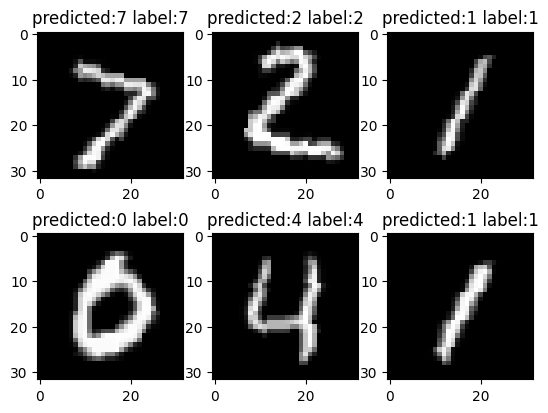

In [5]:
# 画出测试数据集中前6张图片和对应的预测label
fig, axarr = plt.subplots(2, 3)
counter = 0   # 显示的图片的id
images, labels = next(iter(test_loader))  # (BS, 1, 32, 32) (BS)
images, labels = images.to(device), labels.to(device)
outputs = model(images)    # (BS, 1, 32, 32)->(BS, 10)
max_values, max_indexes = torch.max(outputs, dim=-1)  # max_indexes: (BS)
for i in range(2):
    for j in range(3):
        image = images[counter]    # (BS, 1, 32, 32)->(1, 32, 32)
        label = labels[counter]    # (BS)->(1)
        axarr[i][j].imshow(image.squeeze().detach().cpu(), cmap="gray")    # (1, 32, 32)->(32, 32)  "gray"
        axarr[i][j].set_title(f"predicted:{max_indexes[counter]} label:{label}")
        counter += 1

# 显示所有图片
plt.show()
